In [75]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

import torchvision
import torchvision.models as models
import torchvision.datasets as D
import torchvision.transforms as transforms
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import time

In [2]:
import sys
sys.executable

'C:\\Users\\abdul\\Projects\\projects\\Scripts\\python.exe'

In [3]:
from torch.utils.tensorboard import SummaryWriter
# %load_ext tensorboard 
# %tensorboard --logdir=runs

In [4]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

device = torch.device("cuda:0")
# device = torch.device("cpu")
print(device)

cuda:0


In [5]:
#@title Model

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.convnet1 = nn.Sequential(
                            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3),
                            nn.BatchNorm2d(8),
                            nn.ReLU(),
                            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3),
                            nn.BatchNorm2d(8),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.convnet2 = nn.Sequential(
                            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2),
                            nn.BatchNorm2d(16),
                            nn.ReLU(),
                            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
                            nn.BatchNorm2d(16),
                            nn.ReLU(),
                            nn.AdaptiveAvgPool2d(1)
        )
        self.FCs      = nn.Sequential(
                            nn.Linear(in_features=16, out_features=16),
                            nn.ReLU(),
                            nn.Dropout(),
                            nn.Linear(in_features=16, out_features=10)
        )


    def forward(self, x):
        x = self.convnet1(x)
        x = self.convnet2(x)
        x = x.flatten(start_dim=1)
        x = self.FCs(x)
        return x

In [6]:
!ls

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [7]:
train_data = D.MNIST(
    root = "./", 
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=0.1307, std=0.3081)]),
    download=True
)
test_data = D.MNIST(
    root = "./", 
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=0.1307, std=0.3081)]),
    train=False,
    download=True
)


# train_data = D.CIFAR10(
#     root = "cifar", 
#     transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=0.5, std=0.5)]),
#     download=True
# )
# test_data = D.CIFAR10(
#     root = "cifar", 
#     transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=0.5, std=0.5)]),
#     train=False,
#     download=True
# )
# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [8]:
len(train_data), len(test_data)

(60000, 10000)

In [11]:
BATCH_SIZE = 9984-512
train_loader = data.DataLoader(train_data, BATCH_SIZE, shuffle=True, num_workers=0) 
test_loader = data.DataLoader(test_data, BATCH_SIZE, shuffle=False, num_workers=0) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


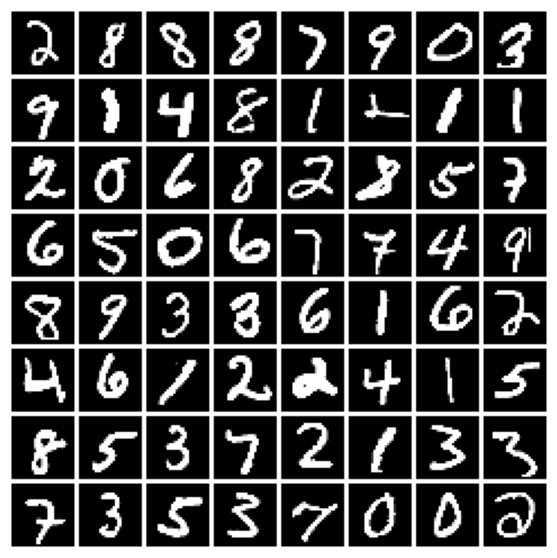

In [76]:
images, labels = next(iter(train_loader))
img_grid = make_grid(images[:64, ...], pad_value=1, nrows=10)
plt.figure(figsize=(10,10))
plt.axis("off")
plt.imshow(img_grid.permute(1,2,0))

In [9]:
model = Model().to(device)
model

Model(
  (convnet1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convnet2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): AdaptiveAvgPool2d(output_size=1)
  )
  (FCs): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_fea

In [13]:
sample  = next(iter(train_loader))
sample[1].shape

torch.Size([9472])

In [14]:
y = model(sample[0].cuda())

In [15]:
y.shape

torch.Size([9472, 10])

In [16]:
img_grid = torchvision.utils.make_grid(sample[0])

In [17]:
torch.cuda.empty_cache()

In [18]:
tb = SummaryWriter("runs/tb2")

tb.add_image("image_grid", img_grid)
tb.add_graph(model, sample[0].cuda())
# tb.close()

In [ ]:
!pip install wandb -q
import wandb

!wandb login

In [ ]:
wandb.init(project='common-ml-errors')
wandb.watch(model, log='all')

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, min_lr=0.00001, verbose=True)

In [11]:
def timeit(f):
    def timed(*args, **kw):
        start_time = time.time()
        result = f(*args, **kw)
        elapsed_time = time.time() - start_time

#         wandb.log({f'Elapsed Time': elapsed_time})
        # print({f'Elapsed Time': elapsed_time})
        tb.add_scalar('Time Elapsed', elapsed_time)
        return result

    return timed

In [12]:
def train_epoch(loader, model, criterion, optimizer, scheduler, device):
    epoch_loss = 0
    epoch_correct = 0
    model.train()
    start_time = time.time()
    for i, (images, labels) in enumerate(loader):
        torch.cuda.empty_cache()
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad(set_to_none=True)
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        scheduler.step(loss)

        epoch_loss += loss.item()
        acc = output.argmax(dim=1).eq(labels).sum().item()
        epoch_correct += acc

#         wandb.log({'Train Loss': loss.item(), 'Train Accuracy': acc/labels.shape[0]})
#         tb.add_scalar('Train Loss', loss.item(), epoch)
#         tb.add_scalar('Train Accuracy', acc/labels.shape[0], epoch)
        # print({'Train Loss': loss.item(), 'Train Accuracy': acc/images.shape[0]})

    elapsed_time = time.time() - start_time
#     wandb.log({f'Elapsed Time': elapsed_time})
    print({f'Elapsed Time': elapsed_time})
#     tb.add_scalar('Time Elapsed', elapsed_time, epoch)
    return epoch_loss, epoch_correct

In [13]:
@torch.no_grad()
def test(loader, model, criterion, device):
    total_loss = 0
    correct = 0
    model.eval()
    # with torch.no_grad():
    for (images, labels) in loader:
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        loss = criterion(output, labels)
        acc = output.argmax(dim=1).eq(labels).sum().item()
        total_loss += loss.item()
        correct += acc
#     wandb.log({'Test Loss': total_loss, 'Test Accuracy': correct / 10000})
    print({'Test Loss': total_loss, 'Test Accuracy': correct / 10000})
    return total_loss, correct

In [57]:
torch.cuda.empty_cache()

In [58]:
BATCH_SIZE = int(4096*5)
print(BATCH_SIZE)
train_loader = data.DataLoader(train_data, BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True) 
test_loader = data.DataLoader(test_data, BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True) 

20480


In [69]:
EPOCHS = 20
for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(train_loader, model, criterion, optimizer, scheduler, device)
    test_loss, test_acc = test(test_loader, model, criterion, device)
#     tb.add_scalars('Losses', {'train': train_loss, 'test': test_loss}, epoch)
#     tb.add_scalars('Acc', {'train': train_acc, 'test': test_acc}, epoch)

{'Elapsed Time': 8.277518033981323}
{'Test Loss': 0.716988742351532, 'Test Accuracy': 0.9379}
{'Elapsed Time': 7.496715784072876}
{'Test Loss': 0.6891948580741882, 'Test Accuracy': 0.9355}
{'Elapsed Time': 7.5213258266448975}
{'Test Loss': 0.66400545835495, 'Test Accuracy': 0.943}
{'Elapsed Time': 7.746811151504517}
{'Test Loss': 0.6423990726470947, 'Test Accuracy': 0.9419}
{'Elapsed Time': 7.743400573730469}
{'Test Loss': 0.6216387152671814, 'Test Accuracy': 0.9451}
{'Elapsed Time': 7.613421678543091}
{'Test Loss': 0.6098549365997314, 'Test Accuracy': 0.9485}
{'Elapsed Time': 8.034040689468384}
{'Test Loss': 0.5846220254898071, 'Test Accuracy': 0.9479}
{'Elapsed Time': 8.192450046539307}
{'Test Loss': 0.571475088596344, 'Test Accuracy': 0.9515}
{'Elapsed Time': 7.675893306732178}
{'Test Loss': 0.5563748478889465, 'Test Accuracy': 0.9539}
{'Elapsed Time': 7.5492706298828125}
{'Test Loss': 0.5373739004135132, 'Test Accuracy': 0.9532}
{'Elapsed Time': 7.447328090667725}
{'Test Loss': 0.5

In [75]:
torch.cuda.device_count()

1

In [ ]:
# tb.close()

In [61]:
PATH = "./cnn_mnist.pth"
torch.save(model.state_dict(), PATH)

In [73]:
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([]).to(device)
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
    return all_preds

In [63]:
len(test_data)

10000

In [65]:
model.eval()
2

2

In [67]:
test_preds = get_all_preds(model, test_loader).cpu()
print(test_preds.argmax(1).eq(test_data.test_labels).sum().item(), 'correctly labeled out of', len(test_data))
print('Accuracy on Test Set:', test_preds.argmax(1).eq(test_data.targets).sum().item() / len(test_data) * 100)

9578 correctly labeled out of 10000
Accuracy on Test Set: 95.78


In [81]:
torch.where(~test_preds.argmax(1).eq(test_data.test_labels))

(tensor([   8,   18,  151,  158,  167,  185,  195,  247,  259,  264,  290,  318,
          320,  321,  326,  340,  352,  359,  362,  445,  447,  449,  478,  490,
          495,  528,  582,  591,  593,  597,  613,  646,  659,  674,  684,  717,
          720,  726,  740,  741,  797,  882,  883,  894,  898,  924,  926,  936,
          938,  947,  957,  958, 1014, 1033, 1039, 1072, 1107, 1112, 1119, 1166,
         1182, 1191, 1202, 1204, 1208, 1217, 1224, 1226, 1232, 1247, 1256, 1259,
         1260, 1283, 1299, 1326, 1393, 1394, 1404, 1409, 1425, 1429, 1441, 1466,
         1500, 1530, 1549, 1551, 1581, 1616, 1618, 1627, 1634, 1637, 1641, 1654,
         1678, 1681, 1695, 1709, 1727, 1737, 1754, 1808, 1839, 1847, 1878, 1901,
         1903, 1913, 1941, 1952, 2016, 2035, 2040, 2044, 2052, 2073, 2093, 2099,
         2109, 2118, 2129, 2130, 2135, 2162, 2182, 2186, 2189, 2200, 2222, 2224,
         2225, 2237, 2266, 2280, 2293, 2299, 2300, 2325, 2329, 2351, 2369, 2380,
         2395, 2406, 2408, 2

Predicted Label: 7 - seven
Actual Label: 9 - nine


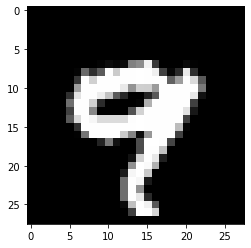

In [82]:
idx = 3587
classes = test_data.classes
image, label = test_data[idx]
plt.imshow(image.squeeze(), cmap="gray")
print(f"Predicted Label: {classes[int(test_preds.argmax(1)[idx])]}\nActual Label: {classes[label]}")

In [ ]:
# wandb.finish()